PJM 180 gigawatts
More than 1,000 companies are members of PJM, which serves 65 million customers and has 180 gigawatts of generating capacity. With 1,376 generation sources, 84,236 miles (135,560 km) of transmission lines and 6,038 transmission substations, PJM delivered 807 terawatt-hours of electricity in 2018.

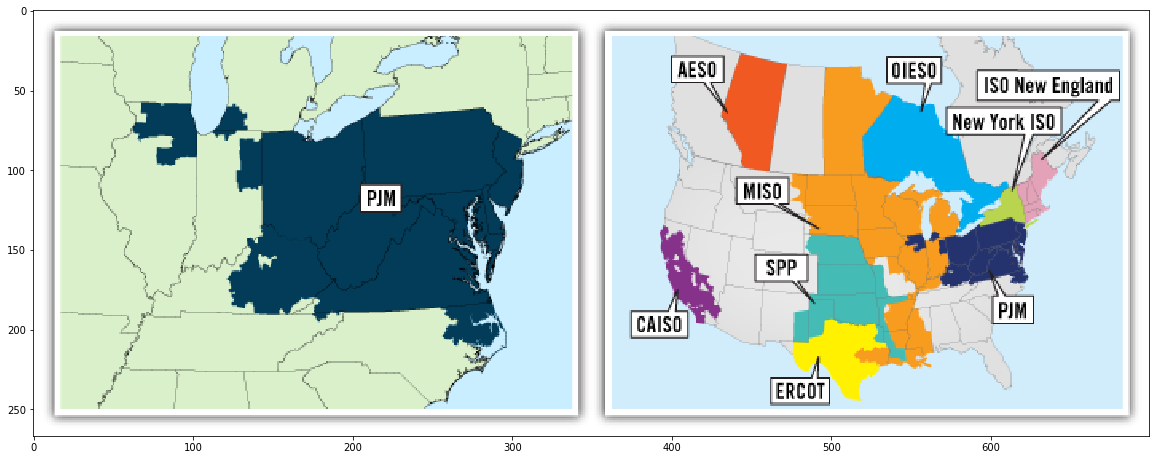

In [1]:
#https://learn.pjm.com/who-is-pjm/where-we-operate.aspx
import matplotlib.pyplot as plt 
img_path = 'PJM.png'
img_p = plt.imread(img_path)
plt.figure(figsize=(20,10))
plt.imshow(img_p)

**Get 100 stations for state and eventually send each id to the python script below to get the weather reported for each id**


Get a Subset of Stations
There are certain filters that can be applied. You can limit stations to a certain geographical location using a FIPS (Federal Information Processing System) code. I don't know if there's a central source for these codes, but here are some.

Since it's an excel sheet and not everyone can open it, here's a portion of it reproduced:

01 - Alabama|
02 - Alaska|
04 - Arizona|
05 - Arkansas|
06 - California|
08 - Colorado|
09 - Connecticut|
**10 - Delaware|**
**11 - District of Columbia|**
12 - Florida|
13 - Georgia|
15 - Hawaii|
16 - Idaho|
**! 17 - Illinois|**
18 - Indiana|
19 - Iowa|
20 - Kansas|
**! 21 - Kentucky|**
22 - Louisiana|
23 - Maine|
**24 - Maryland|**
25 - Massachusetts|
**! 26 - Michigan|**
27 - Minnesota|
28 - Mississippi|
29 - Missouri|
30 - Montana|
31 - Nebraska|
32 - Nevada|
33 - New Hampshire|
**34 - New Jersey|**
35 - New Mexico|
36 - New York|
**! 37 - North Carolina|**
38 - North Dakota|
**39 - Ohio|**
40 - Oklahoma|
41 - Oregon|
**42 - Pennsylvania|**
44 - Rhode Island|
45 - South Carolina|
46 - South Dakota|
47 - Tennessee|
48 - Texas|
49 - Utah|
50 - Vermont|
**51 - Virginia|**
53 - Washington|
**54 - West Virginia|**
55 - Wisconsin|
56 - Wyoming|

In [1]:
token= {'token':"FfYxVKYFuLVuWcFVFztBmmQvZDyPsPgJ"}

In [64]:
import requests
import json
import pandas as pd
FIPS = [34,42,39,10,11,24,51,54]
FIPS2 = [17,21,26,37]
state = ['New Jersey','Pennsylvania','Ohio',
         'Delaware','District of Columbia',
         'Maryland','Virginia','West Virginia']

df_fips = pd.DataFrame()

for index, location in enumerate(FIPS):
    url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:{location}&limit=100&sortfield=mindate'
    r = requests.get(url, headers=token)
    print(location,r)
    response = r.json()
    df = pd.DataFrame.from_dict(response['results'])
    df['state'] = state[index]
    df_fips = pd.concat([df_fips,df])



34 <Response [200]>
42 <Response [200]>
39 <Response [200]>
10 <Response [200]>
11 <Response [200]>
24 <Response [200]>
51 <Response [200]>
54 <Response [200]>


In [65]:
df_fips[['location_type','location']] = df_fips['id'].apply(lambda x: pd.Series(str(x).split(":")))


*   The National Weather Service Cooperative Observer Program (COOP)
*   Global Historical Climatology Network Daily (GHCND)
*   Next-Generation Radar (NEXRAD) is a network of 159 high-resolution S-band Doppler weather radars operated by the National Weather Service
*   Weather Bureau Army Navy (WBAN)







In [66]:
df_fips.groupby('location_type').count()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,state,location
location_type,,,,,,,,,,,
COOP,85,85,85,85,85,85,85,85,85,85,85
GHCND,609,625,625,625,625,625,625,609,625,625,625
NEXRAD,18,20,20,20,20,20,20,18,20,20,20
WBAN,3,3,3,3,3,3,3,3,3,3,3


In [67]:
df_fips.to_csv('station_details_addition.csv',sep='|',index=False)

In [68]:
GHCND = df_fips[df_fips['location_type']=='GHCND']
GHCDN_list = sorted(GHCND['location'].tolist(),reverse=True)

  

In [69]:
len(GHCDN_list)

625

In [70]:
import json

with open('config.json') as conf_file:
    config = json.load(conf_file)



In [71]:
config['params']['weather_stations'] = GHCDN_list
with open('config_new.json', 'w') as json_file:
    json.dump(config, json_file,indent=1)

In [72]:
limit = 1000

base_url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit={limit}&stationid=GHCND:"

weather_stations = GHCDN_list

weather_features = ["station_dt_key","date","station","PRCP","SNOW","SNWD","AWND","TMAX","TMIN"]

start_date = "-01-01"

end_date = "-12-31"

In [73]:
import time
import requests
import pandas as pd
import json

not_found = []


def get_url(url,token,station,year):   
    r = requests.get(url, headers=token)
    print(r)
    
    try:
        response = r.json()
    
    except:
        print(f'Error {station}')
        station_not_found = {'url':url,'station':station,'year':year,'error':r}
        not_found.append(station_not_found)
        return None


    if bool(response):
        count = response['metadata']['resultset']['count']
        print(count)
        return count
    
    else:
        print(f'No Records Found for {station}')
        station_not_found = {'url':url,'station':station,'year':year}
        not_found.append(station_not_found)
        return None


    
def fetch_weather_data(base_url, weather_stations,start_date, end_date, token):
    
    years = ['2020']
    
    df_stations = pd.DataFrame()
    
    for year in years:
        
        for index, station in enumerate(weather_stations): 
            offset = 0


            print(f'{index}: ',station, year)
            #

            url = f'{base_url}{station}&units=standard&startdate={year}{start_date}&enddate={year}{end_date}&includemetadata=True'

            #url = (base_url + station + '&startdate=' + start_date + '&enddate=' 
            #       + end_date + f'&units=standard&limit=50&offset={offset}&%includemetadata=True')

            count = get_url(url,token,station,year)

            if bool(count):

                while offset <= count:
                    loop_url = f'{base_url}{station}&offset={offset}&units=standard&startdate={year}{start_date}&enddate={year}{end_date}'
                    print(loop_url)
                    r = requests.get(loop_url, headers=token)
                    #print(r)
                    try:
                        response = r.json()
                        interval_data = reformat_data(r.text) 
                        df_stations = pd.concat([df_stations,interval_data])
                        offset = offset + limit
                        print('-- done.')
                    except:
                        continue
                    

            #sleep for 10 seconds to avoid going over rate limit.
            time.sleep(10) 

    return df_stations


def reformat_data(json_text):
    """
    Convert data to denormalized pandas dataframe. This format will allow easier analysis and better 
    fit within a typical data warehouse schema.
    """
    
    #convert records from nested json to flat pandas dataframe. 
    api_records = json.loads(json_text)['results']
    df = pd.pivot_table(pd.DataFrame(api_records), index=['date', 'station'], columns='datatype', values='value')
    reshaped_df = df.rename_axis(None, axis=1).reset_index()
    
    #clean up the date and station fields
    #reshaped_df.date = reshaped_df.date.str.slice(0, 10)
    #reshaped_df.station = reshaped_df.station.str.slice(6, 17)

    #add a primary key for useful for updating/inserting records in a database. 
    reshaped_df['station_dt_key']=reshaped_df['station'].astype(str)+'_'+reshaped_df['date'].str.slice(0, 10)

    #filter for requested features, replace NAs with 0.
    final_df = reshaped_df.filter(items=weather_features)
    final_df.fillna(0.0)
    
    return final_df
        

In [74]:
df_stations = fetch_weather_data(base_url,weather_stations,start_date,end_date,token)

0:  USW00093725 2020
<Response [200]>
No Records Found for USW00093725
1:  USW00014773 2020
<Response [200]>
No Records Found for USW00014773
2:  USW00014767 2020
<Response [200]>
No Records Found for USW00014767
3:  USW00014734 2020
<Response [200]>
2541
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USW00014734&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USW00014734&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USW00014734&offset=2000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
4:  USW00013781 2020
<Response [200]>
2534
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USW00013781&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.

-- done.
56:  USC00466343 2020
<Response [200]>
No Records Found for USC00466343
57:  USC00466250 2020
<Response [200]>
No Records Found for USC00466250
58:  USC00466207 2020
<Response [200]>
No Records Found for USC00466207
59:  USC00466207 2020
<Response [200]>
No Records Found for USC00466207
60:  USC00466178 2020
<Response [200]>
No Records Found for USC00466178
61:  USC00466163 2020
<Response [200]>
No Records Found for USC00466163
62:  USC00466140 2020
<Response [200]>
No Records Found for USC00466140
63:  USC00465970 2020
<Response [200]>
No Records Found for USC00465970
64:  USC00465705 2020
<Response [200]>
No Records Found for USC00465705
65:  USC00465672 2020
<Response [200]>
No Records Found for USC00465672
66:  USC00465621 2020
<Response [200]>
No Records Found for USC00465621
67:  USC00465563 2020
<Response [200]>
1138
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00465563&offset=0&units=standard&startdate=2020-01-01&enddate=2

-- done.
123:  USC00449146 2020
<Response [200]>
No Records Found for USC00449146
124:  USC00449135 2020
<Response [200]>
No Records Found for USC00449135
125:  USC00449126 2020
<Response [200]>
No Records Found for USC00449126
126:  USC00449020 2020
<Response [200]>
No Records Found for USC00449020
127:  USC00448984 2020
<Response [200]>
No Records Found for USC00448984
128:  USC00448949 2020
<Response [200]>
No Records Found for USC00448949
129:  USC00448894 2020
<Response [200]>
1010
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00448894&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00448894&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
130:  USC00448888 2020
<Response [200]>
No Records Found for USC00448888
131:  USC00448787 2020
<Response [200]>
No Records Found for USC00448787
132:  USC00

<Response [200]>
No Records Found for USC00442394
192:  USC00442368 2020
<Response [200]>
No Records Found for USC00442368
193:  USC00442245 2020
<Response [200]>
1263
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00442245&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00442245&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
194:  USC00442208 2020
<Response [200]>
1178
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00442208&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00442208&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
195:  USC00442155 2020
<Response [200]>
No Records Found for USC00442155
196:  USC004

-- done.
248:  USC00367239 2020
<Response [200]>
No Records Found for USC00367239
249:  USC00367149 2020
<Response [200]>
No Records Found for USC00367149
250:  USC00366927 2020
<Response [200]>
827
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00366927&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
251:  USC00366914 2020
<Response [200]>
No Records Found for USC00366914
252:  USC00366719 2020
<Response [200]>
No Records Found for USC00366719
253:  USC00366531 2020
<Response [200]>
No Records Found for USC00366531
254:  USC00366233 2020
<Response [200]>
172
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00366233&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
255:  USC00365720 2020
<Response [200]>
No Records Found for USC00365720
256:  USC00365479 2020
<Response [200]>
No Records Found for USC00365479
257:  USC00365347 2020
<Response [200]>
No R

-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00338609&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
322:  USC00338534 2020
<Response [200]>
No Records Found for USC00338534
323:  USC00338366 2020
<Response [200]>
No Records Found for USC00338366
324:  USC00338313 2020
<Response [200]>
No Records Found for USC00338313
325:  USC00338308 2020
<Response [200]>
No Records Found for USC00338308
326:  USC00338180 2020
<Response [200]>
No Records Found for USC00338180
327:  USC00337920 2020
<Response [200]>
No Records Found for USC00337920
328:  USC00337700 2020
<Response [200]>
No Records Found for USC00337700
329:  USC00337650 2020
<Response [200]>
No Records Found for USC00337650
330:  USC00337145 2020
<Response [200]>
No Records Found for USC00337145
331:  USC00337080 2020
<Response [200]>
No Records Found for USC00337080
332:  USC00336781 2020
<Response [200]>
1163
https://www.ncdc.noaa.gov/cdo-web/api/v

<Response [200]>
No Records Found for USC00330663
395:  USC00330622 2020
<Response [200]>
No Records Found for USC00330622
396:  USC00330610 2020
<Response [200]>
No Records Found for USC00330610
397:  USC00330315 2020
<Response [200]>
No Records Found for USC00330315
398:  USC00330274 2020
<Response [200]>
No Records Found for USC00330274
399:  USC00330251 2020
<Response [200]>
No Records Found for USC00330251
400:  USC00330083 2020
<Response [200]>
No Records Found for USC00330083
401:  USC00306774 2020
<Response [200]>
1266
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00306774&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00306774&offset=1000&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
402:  USC00301413 2020
<Response [200]>
No Records Found for USC00301413
403:  USC00289910 2020
<Response [200]>
No 

-- done.
457:  USC00280729 2020
<Response [200]>
No Records Found for USC00280729
458:  USC00280690 2020
<Response [200]>
No Records Found for USC00280690
459:  USC00201634 2020
<Response [200]>
No Records Found for USC00201634
460:  USC00189750 2020
<Response [200]>
No Records Found for USC00189750
461:  USC00189435 2020
<Response [200]>
No Records Found for USC00189435
462:  USC00189405 2020
<Response [200]>
No Records Found for USC00189405
463:  USC00189115 2020
<Response [200]>
No Records Found for USC00189115
464:  USC00189065 2020
<Response [200]>
No Records Found for USC00189065
465:  USC00189035 2020
<Response [200]>
No Records Found for USC00189035
466:  USC00188990 2020
<Response [200]>
No Records Found for USC00188990
467:  USC00188877 2020
<Response [200]>
No Records Found for USC00188877
468:  USC00188780 2020
<Response [200]>
No Records Found for USC00188780
469:  USC00188715 2020
<Response [200]>
No Records Found for USC00188715
470:  USC00188670 2020
<Response [200]>
No

551:  USC00158397 2020
<Response [200]>
No Records Found for USC00158397
552:  USC00151386 2020
<Response [200]>
No Records Found for USC00151386
553:  USC00128956 2020
<Response [200]>
No Records Found for USC00128956
554:  USC00079605 2020
<Response [200]>
186
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:USC00079605&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
555:  USC00079600 2020
<Response [200]>
No Records Found for USC00079600
556:  USC00078510 2020
<Response [200]>
No Records Found for USC00078510
557:  USC00078508 2020
<Response [200]>
No Records Found for USC00078508
558:  USC00078269 2020
<Response [200]>
No Records Found for USC00078269
559:  USC00076410 2020
<Response [200]>
No Records Found for USC00076410
560:  USC00076405 2020
<Response [200]>
No Records Found for USC00076405
561:  USC00076102 2020
<Response [200]>
No Records Found for USC00076102
562:  USC00076020 2020
<Response [200]>
No Records F

618:  US1DCDC0009 2020
<Response [200]>
137
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&stationid=GHCND:US1DCDC0009&offset=0&units=standard&startdate=2020-01-01&enddate=2020-12-31
-- done.
619:  US1DCDC0008 2020
<Response [200]>
No Records Found for US1DCDC0008
620:  US1DCDC0007 2020
<Response [200]>
No Records Found for US1DCDC0007
621:  US1DCDC0006 2020
<Response [200]>
No Records Found for US1DCDC0006
622:  US1DCDC0003 2020
<Response [200]>
No Records Found for US1DCDC0003
623:  US1DCDC0002 2020
<Response [200]>
No Records Found for US1DCDC0002
624:  US1DCDC0001 2020
<Response [200]>
No Records Found for US1DCDC0001


**Output for above**

In [59]:
export_not_found = pd.DataFrame(not_found)
export_not_found.to_csv('2020_kickout_new.csv',sep='|',index=False)

In [60]:
export_not_found

,url,station,year
0,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USW00014881,2020
1,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USW00014834,2020
2,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USW00013745,2020
3,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USW00013713,2020
4,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USC00469605,2020
...,...,...,...
361,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USC00110492,2020
362,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USC00110286,2020
363,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USC00110187,2020
364,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,USC00110055,2020


In [61]:
import matplotlib as plot
import seaborn as sns

In [62]:
df_stations

,station_dt_key,date,station,PRCP,SNOW,SNWD,AWND,TMAX,TMIN
0,GHCND:USW00093820_2020-01-01,2020-01-01T00:00:00,GHCND:USW00093820,0.00,0.0,0.0,9.8,50.0,35.0
1,GHCND:USW00093820_2020-01-02,2020-01-02T00:00:00,GHCND:USW00093820,0.20,0.0,0.0,12.3,56.0,39.0
2,GHCND:USW00093820_2020-01-03,2020-01-03T00:00:00,GHCND:USW00093820,0.65,0.0,0.0,6.0,56.0,52.0
3,GHCND:USW00093820_2020-01-04,2020-01-04T00:00:00,GHCND:USW00093820,0.04,0.0,0.0,11.4,52.0,36.0
4,GHCND:USW00093820_2020-01-05,2020-01-05T00:00:00,GHCND:USW00093820,0.00,0.0,0.0,11.0,50.0,31.0
...,...,...,...,...,...,...,...,...,...
8,GHCND:USC00110137_2020-08-03,2020-08-03T00:00:00,GHCND:USC00110137,0.11,0.0,0.0,NaN,82.0,68.0
9,GHCND:USC00110137_2020-08-04,2020-08-04T00:00:00,GHCND:USC00110137,0.21,0.0,0.0,NaN,82.0,59.0
10,GHCND:USC00110137_2020-08-05,2020-08-05T00:00:00,GHCND:USC00110137,0.00,0.0,0.0,NaN,83.0,58.0
11,GHCND:USC00110137_2020-08-06,2020-08-06T00:00:00,GHCND:USC00110137,0.00,0.0,0.0,NaN,79.0,59.0


In [63]:
df_stations.to_csv('Raw_2020_NOAA_new.csv',sep='|',index=False)

In [23]:
clean_df_stations = df_stations.drop_duplicates('station_dt_key').fillna(0)
clean_df_stations['date'] = clean_df_stations['date'].apply(lambda x: x[:10])
clean_df_stations['month'] = clean_df_stations['date'].apply(lambda x: x[5:7])

In [24]:
clean_df_stations['TDIFF'] = clean_df_stations['TMAX'] - clean_df_stations['TMIN']

In [25]:
f, axes = plt.subplots(2, 4, figsize=(20, 10))

visual_data = clean_df_stations

sns.lineplot(x='date',y='PRCP',data=visual_data,hue='month',ax=axes[0,0],palette='colorblind')
sns.lineplot(x='date',y='AWND',data=visual_data,hue='month',ax=axes[1,0],palette='colorblind')
sns.lineplot(x='date',y='SNOW',data=visual_data,hue='month',ax=axes[0,1],palette='colorblind')
sns.lineplot(x='date',y='SNWD',data=visual_data,hue='month',ax=axes[1,1],palette='colorblind')
sns.lineplot(x='date',y='TMAX',data=visual_data,hue='month',ax=axes[0,2],palette='colorblind')
sns.lineplot(x='date',y='TMIN',data=visual_data,hue='month',ax=axes[1,2],palette='colorblind')
sns.lineplot(x='date',y='TDIFF',data=visual_data,hue='month',ax=axes[0,3],palette='colorblind')
sns.countplot(x='month',data=visual_data,ax=axes[1,3],palette='colorblind')

NameError: name 'plt' is not defined

PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)


SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)


SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)


TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on
Daily Form pdf file


TMIN = Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on
Daily Form pdf file

In [192]:
df_complete = clean_df_stations.merge(df_fips,left_on='station',right_on='id',how='left')
df_complete

,station_dt_key,date,station,PRCP,SNOW,SNWD,AWND,TMAX,TMIN,month,...,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,state,location_type,location
0,GHCND:USW00014734_2016-01-01,2016-01-01,GHCND:USW00014734,0.00,0.0,0.0,12.8,43.0,34.0,01,...,2020-07-05,40.682500,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1.0000,GHCND:USW00014734,METERS,-74.169400,New Jersey,GHCND,USW00014734
1,GHCND:USW00014734_2016-01-02,2016-01-02,GHCND:USW00014734,0.00,0.0,0.0,9.4,42.0,30.0,01,...,2020-07-05,40.682500,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1.0000,GHCND:USW00014734,METERS,-74.169400,New Jersey,GHCND,USW00014734
2,GHCND:USW00014734_2016-01-03,2016-01-03,GHCND:USW00014734,0.00,0.0,0.0,10.3,47.0,28.0,01,...,2020-07-05,40.682500,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1.0000,GHCND:USW00014734,METERS,-74.169400,New Jersey,GHCND,USW00014734
3,GHCND:USW00014734_2016-01-04,2016-01-04,GHCND:USW00014734,0.00,0.0,0.0,17.2,35.0,14.0,01,...,2020-07-05,40.682500,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1.0000,GHCND:USW00014734,METERS,-74.169400,New Jersey,GHCND,USW00014734
4,GHCND:USW00014734_2016-01-05,2016-01-05,GHCND:USW00014734,0.00,0.0,0.0,9.8,31.0,10.0,01,...,2020-07-05,40.682500,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",1.0000,GHCND:USW00014734,METERS,-74.169400,New Jersey,GHCND,USW00014734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43015,GHCND:US1DCDC0009_2016-12-16,2016-12-16,GHCND:US1DCDC0009,0.00,0.0,0.0,0.0,0.0,0.0,12,...,2020-06-25,38.876594,"WASHINGTON 2.0 SSW, DC US",0.4948,GHCND:US1DCDC0009,METERS,-77.022402,District of Columbia,GHCND,US1DCDC0009
43016,GHCND:US1DCDC0009_2016-12-19,2016-12-19,GHCND:US1DCDC0009,0.01,0.0,0.0,0.0,0.0,0.0,12,...,2020-06-25,38.876594,"WASHINGTON 2.0 SSW, DC US",0.4948,GHCND:US1DCDC0009,METERS,-77.022402,District of Columbia,GHCND,US1DCDC0009
43017,GHCND:US1DCDC0009_2016-12-20,2016-12-20,GHCND:US1DCDC0009,0.00,0.0,0.0,0.0,0.0,0.0,12,...,2020-06-25,38.876594,"WASHINGTON 2.0 SSW, DC US",0.4948,GHCND:US1DCDC0009,METERS,-77.022402,District of Columbia,GHCND,US1DCDC0009
43018,GHCND:US1DCDC0009_2016-12-22,2016-12-22,GHCND:US1DCDC0009,0.00,0.0,0.0,0.0,0.0,0.0,12,...,2020-06-25,38.876594,"WASHINGTON 2.0 SSW, DC US",0.4948,GHCND:US1DCDC0009,METERS,-77.022402,District of Columbia,GHCND,US1DCDC0009


In [193]:
df_complete.to_csv('2016_NOAA_addition.csv',sep='|',index=False)

In [252]:
!pip install plotly

     |████████████████████████████████| 11.5 MB 9.1 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=26517e27e301a1bd05e2132513efdc9c571f904aba674a4c958d064580ea0c83
  Stored in directory: /Users/adamgoldstein/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
import plotly.express as px

fig = px.scatter_mapbox(df_complete, lat="latitude", lon="longitude", hover_name="station",
                        color_discrete_sequence=["fuchsia"], zoom=3, height=700)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

NameError: name 'df_complete' is not defined